# KOCH PAIRED

In [2]:
import os
from glob import glob

import numpy as np
from scipy.signal import butter, filtfilt, find_peaks

import torch
from torch.utils.data import Dataset


class KochPairedBeatsDataset(Dataset):
    def __init__(self, npz_path="koch_pairs.npz", augment=False):
        """
        npz_path: path to the koch_pairs.npz file
        augment: if True, apply very light noise / jitter augmentations
        """
        data = np.load(npz_path, allow_pickle=True)
        self.ecg_beats = data["ecg_beats"]  # (N, C_ecg, T)
        self.mcg_beats = data["mcg_beats"]  # (N, C_mcg, T)
        self.fs = int(data["fs"][0])
        self.augment = augment

    def __len__(self):
        return self.ecg_beats.shape[0]

    def _augment(self, x):
        """
        x: numpy array (C, T)
        very light augmentations: small Gaussian noise and tiny time shift
        """
        # small noise
        x = x + 0.01 * np.random.randn(*x.shape).astype(np.float32)

        # tiny circular time shift up to ±20 samples
        max_shift = 20
        shift = np.random.randint(-max_shift, max_shift + 1)
        if shift != 0:
            x = np.roll(x, shift, axis=1)

        return x

    def __getitem__(self, idx):
        ecg = self.ecg_beats[idx]  # (C_ecg, T)
        mcg = self.mcg_beats[idx]  # (C_mcg, T)

        if self.augment:
            ecg = self._augment(ecg)
            mcg = self._augment(mcg)

        # convert to torch tensors
        ecg = torch.from_numpy(ecg)  # float32, shape (C_ecg, T)
        mcg = torch.from_numpy(mcg)  # float32, shape (C_mcg, T)

        return ecg, mcg


#from koch_dataset import KochPairedBeatsDataset
from torch.utils.data import DataLoader

ds = KochPairedBeatsDataset("koch_pairs.npz", augment=False)
print("Num beats:", len(ds))

loader = DataLoader(ds, batch_size=8, shuffle=True)
ecg, mcg = next(iter(loader))
print("ECG batch shape:", ecg.shape)  # expect: torch.Size([8, 32, 2000])
print("MCG batch shape:", mcg.shape)  # expect: torch.Size([8, 100, 2000])


Num beats: 127
ECG batch shape: torch.Size([8, 32, 2000])
MCG batch shape: torch.Size([8, 100, 2000])


# PTB Beats Dataset

In [3]:
import numpy as np
import torch
from torch.utils.data import Dataset


class PTBBeatsDataset(Dataset):
    def __init__(self, npz_path="ptb_beats.npz", augment=True):
        data = np.load(npz_path, allow_pickle=True)
        self.beats = data["beats"]        # (N, 12, 2000)
        self.fs = int(data["fs"][0])
        self.augment = augment

    def __len__(self):
        return self.beats.shape[0]

    def _augment(self, x):
        # x: (12, T)
        x = x + 0.01 * np.random.randn(*x.shape).astype(np.float32)  # noise
        max_shift = 20
        shift = np.random.randint(-max_shift, max_shift + 1)
        if shift != 0:
            x = np.roll(x, shift, axis=1)
        return x

    def __getitem__(self, idx):
        beat = self.beats[idx]
        if self.augment:
            beat = self._augment(beat)
        return torch.from_numpy(beat)



from torch.utils.data import DataLoader

ds_ptb = PTBBeatsDataset("ptb_beats.npz", augment=True)
loader_ptb = DataLoader(ds_ptb, batch_size=32, shuffle=True)

batch = next(iter(loader_ptb))
print(batch.shape)  # torch.Size([32, 12, 2000])


torch.Size([32, 12, 2000])


# Model

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional


class DepthwiseSeparableConv1d(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, stride=1, padding=0):
        super().__init__()
        self.depthwise = nn.Conv1d(in_ch, in_ch, kernel_size=kernel_size,
                                   stride=stride, padding=padding, groups=in_ch)
        self.pointwise = nn.Conv1d(in_ch, out_ch, kernel_size=1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x


class MultiScaleBlock(nn.Module):
    """
    Multi-scale depthwise-separable residual block.
    Input: (B, C, T) -> Output: (B, C, T)
    """
    def __init__(self, channels, kernels=(5, 9, 17)):
        super().__init__()
        self.branches = nn.ModuleList()
        for k in kernels:
            pad = k // 2
            self.branches.append(
                DepthwiseSeparableConv1d(channels, channels, kernel_size=k, padding=pad)
            )
        self.bn = nn.BatchNorm1d(channels)
        self.act = nn.ReLU()

    def forward(self, x):
        # x: (B, C, T)
        outs = []
        for conv in self.branches:
            outs.append(conv(x))
        out = sum(outs) / len(outs)  # average branches
        out = self.bn(out)
        out = self.act(out)
        return x + out  # residual


class SMEEBackbone(nn.Module):
    """
    Shared Multi-Scale Efficient Encoder backbone.
    Input: (B, C_bottleneck, T) -> Output: (B, feat_dim)
    """
    def __init__(self, bottleneck_channels=32, n_blocks=3, feat_dim=256):
        super().__init__()
        blocks = []
        for _ in range(n_blocks):
            blocks.append(MultiScaleBlock(bottleneck_channels, kernels=(5, 9, 17)))
        self.blocks = nn.Sequential(*blocks)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(bottleneck_channels, feat_dim)

    def forward(self, x):
        # x: (B, C_bottleneck, T)
        x = self.blocks(x)                 # (B, C_bottleneck, T)
        x = self.global_pool(x).squeeze(-1)  # (B, C_bottleneck)
        x = self.fc(x)                     # (B, feat_dim)
        return x


class ECGEncoderSMEE(nn.Module):
    """
    ECG encoder using SMEE backbone.
    """
    def __init__(self, in_channels=32, bottleneck_channels=32, feat_dim=256):
        super().__init__()
        self.input_proj = nn.Conv1d(in_channels, bottleneck_channels, kernel_size=1)
        self.backbone = SMEEBackbone(bottleneck_channels=bottleneck_channels,
                                     n_blocks=3, feat_dim=feat_dim)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.backbone(x)
        return x


class MCGEncoderSMEE(nn.Module):
    """
    MCG encoder using SMEE backbone. Can share backbone weights with ECG encoder if desired.
    """
    def __init__(
        self,
        in_channels: int = 100,
        bottleneck_channels: int = 32,
        feat_dim: int = 256,
        shared_backbone: Optional[SMEEBackbone] = None,
    ):
        super().__init__()
        self.input_proj = nn.Conv1d(in_channels, bottleneck_channels, kernel_size=1)
        if shared_backbone is None:
            self.backbone = SMEEBackbone(
                bottleneck_channels=bottleneck_channels,
                n_blocks=3,
                feat_dim=feat_dim,
            )
        else:
            self.backbone = shared_backbone  # weight sharing

    def forward(self, x):
        x = self.input_proj(x)
        x = self.backbone(x)
        return x


class Conv1DEncoder(nn.Module):
    """
    Generic 1D CNN encoder for time series.
    Used for ECG (C=12 or 32) and MCG (C=100).
    Input: (B, C, T)
    Output: (B, feat_dim)
    """
    def __init__(self, in_channels, feat_dim=256):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1   = nn.BatchNorm1d(64)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2)
        self.bn2   = nn.BatchNorm1d(128)

        self.conv3 = nn.Conv1d(128, 256, kernel_size=5, stride=2, padding=2)
        self.bn3   = nn.BatchNorm1d(256)

        self.conv4 = nn.Conv1d(256, 256, kernel_size=3, stride=2, padding=1)
        self.bn4   = nn.BatchNorm1d(256)

        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(256, feat_dim)

    def forward(self, x):
        # x: (B, C, T)
        x = F.relu(self.bn1(self.conv1(x)))  # (B, 64, T/2)
        x = F.relu(self.bn2(self.conv2(x)))  # (B, 128, T/4)
        x = F.relu(self.bn3(self.conv3(x)))  # (B, 256, T/8)
        x = F.relu(self.bn4(self.conv4(x)))  # (B, 256, T/16)
        x = self.global_pool(x)              # (B, 256, 1)
        x = x.squeeze(-1)                    # (B, 256)
        x = self.fc(x)                       # (B, feat_dim)
        return x




In [5]:
#from models import ECGEncoderSMEE, MCGEncoderSMEE  
import torch

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

ecg_smee = ECGEncoderSMEE(in_channels=32)
mcg_smee = MCGEncoderSMEE(in_channels=100)

print("ECG SMEE params:", count_params(ecg_smee))
print("MCG SMEE params:", count_params(mcg_smee))

# quick forward test
x_ecg = torch.randn(4, 32, 2000)
x_mcg = torch.randn(4, 100, 2000)
h_e = ecg_smee(x_ecg)
h_m = mcg_smee(x_mcg)
print("Shapes:", h_e.shape, h_m.shape)  # should be: torch.Size([4, 256]) torch.Size([4, 256])


ECG SMEE params: 22464
MCG SMEE params: 24640
Shapes: torch.Size([4, 256]) torch.Size([4, 256])


# Projection Head

In [6]:


class ProjectionHead(nn.Module):
    """
    2-layer MLP projection head.
    Input: (B, feat_dim)
    Output: (B, proj_dim) normalized
    """
    def __init__(self, in_dim=256, proj_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, in_dim)
        self.fc2 = nn.Linear(in_dim, proj_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.normalize(x, p=2, dim=-1)
        return x



def cross_modal_info_nce(z_e, z_m, temperature=0.1):
    """
    Cross-modal InfoNCE loss between ECG (z_e) and MCG (z_m).
    z_e: (B, D) ECG embeddings (L2-normalized)
    z_m: (B, D) MCG embeddings (L2-normalized)

    We compute similarity matrix S = z_e @ z_m^T / T
    and use symmetric loss: ECG→MCG and MCG→ECG.
    """
    assert z_e.shape == z_m.shape
    B, D = z_e.shape

    # cosine similarity (since both are normalized, dot = cos)
    logits = z_e @ z_m.T / temperature  # (B, B)

    targets = torch.arange(B, device=z_e.device)

    # ECG→MCG
    loss_e2m = F.cross_entropy(logits, targets)

    # MCG→ECG (transpose)
    loss_m2e = F.cross_entropy(logits.T, targets)

    loss = 0.5 * (loss_e2m + loss_m2e)
    return loss


# Loss

In [7]:
import torch
import torch.nn.functional as F


def simclr_nt_xent_loss(z1, z2, temperature=0.1):
    """
    z1, z2: (B, D) normalized embeddings from two views of the same batch.
    Returns scalar loss.
    """
    assert z1.shape == z2.shape
    batch_size = z1.shape[0]

    z = torch.cat([z1, z2], dim=0)  # (2B, D)
    sim = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=-1)  # (2B, 2B)

    # Mask to remove self-similarity
    self_mask = torch.eye(2 * batch_size, dtype=torch.bool, device=z.device)
    sim = sim / temperature

    # For each anchor i in 0..2B-1, define positives and negatives
    # Positives: (i, i+B) or (i, i-B) depending on which half
    labels = torch.arange(2 * batch_size, device=z.device)
    labels = (labels + batch_size) % (2 * batch_size)  # positive index for each anchor

    # For cross-entropy, we need logits (2B, 2B-1) and labels
    sim = sim.masked_fill(self_mask, -1e9)

    loss = F.cross_entropy(sim, labels)
    return loss


## New LOss :ECG↔MCG contrastive loss

In [8]:
import torch
import torch.nn.functional as F


def simclr_nt_xent_loss(z1, z2, temperature=0.1):
    """
    Standard NT-Xent (SimCLR) loss for two views.
    z1, z2: (B, D) L2-normalized embeddings.
    """
    assert z1.shape == z2.shape
    B = z1.shape[0]

    z = torch.cat([z1, z2], dim=0)  # (2B, D)
    sim = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=-1)  # (2B, 2B)
    sim = sim / temperature

    labels = torch.arange(2 * B, device=z.device)
    labels = (labels + B) % (2 * B)  # positive for each index is the other view

    # mask self-similarities
    mask = torch.eye(2 * B, dtype=torch.bool, device=z.device)
    sim = sim.masked_fill(mask, -1e9)

    loss = F.cross_entropy(sim, labels)
    return loss


def cross_modal_info_nce(z_e, z_m, temperature=0.1):
    """
    Symmetric cross-modal InfoNCE between ECG (z_e) and MCG (z_m).
    z_e, z_m: (B, D) L2-normalized.
    """
    B = z_e.shape[0]
    logits = z_e @ z_m.T / temperature  # (B, B)
    targets = torch.arange(B, device=z_e.device)

    loss_e2m = F.cross_entropy(logits, targets)
    loss_m2e = F.cross_entropy(logits.T, targets)
    return 0.5 * (loss_e2m + loss_m2e)


def ecg_mcg_contrastive_loss(
    z_e, z_m,
    z_e_aug1=None, z_e_aug2=None,
    z_m_aug1=None, z_m_aug2=None,
    temperature=0.1,
    lambda_within=0.1,
):
    """
    Task-specific ECG<->MCG loss:

    L_total = L_cross(ECG, MCG) + λ (L_within_ECG + L_within_MCG)

    z_e, z_m: (B, D) main ECG/MCG embeddings
    z_e_aug1, z_e_aug2: (B, D) augmented ECG embeddings
    z_m_aug1, z_m_aug2: (B, D) augmented MCG embeddings
    """
    # cross-modal alignment
    loss = cross_modal_info_nce(z_e, z_m, temperature=temperature)

    # within-ECG consistency
    if (z_e_aug1 is not None) and (z_e_aug2 is not None):
        loss_ecg = simclr_nt_xent_loss(z_e_aug1, z_e_aug2, temperature=temperature)
        loss = loss + lambda_within * loss_ecg

    # within-MCG consistency
    if (z_m_aug1 is not None) and (z_m_aug2 is not None):
        loss_mcg = simclr_nt_xent_loss(z_m_aug1, z_m_aug2, temperature=temperature)
        loss = loss + lambda_within * loss_mcg

    return loss


# train_koch_crossmodal_smee

In [ ]:
import torch
from torch.utils.data import DataLoader

#from koch_dataset import KochPairedBeatsDataset
#from models import (ECGEncoderSMEE,MCGEncoderSMEE,ProjectionHead, cross_modal_info_nce,   )


import torch




def train_koch_crossmodal_smee(
    npz_path="koch_pairs.npz",
    batch_size=8,
    lr=1e-3,
    epochs=50,
    device="cpu",
):
    # 1) Dataset & DataLoader
    dataset = KochPairedBeatsDataset(npz_path=npz_path, augment=True)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

    # 2) New encoders: SMEE-based ECG (32 ch) & MCG (100 ch)
    #    (no shared backbone yet, we keep it simple first)
    ecg_encoder = ECGEncoderSMEE(in_channels=32, bottleneck_channels=32, feat_dim=256)
    mcg_encoder = MCGEncoderSMEE(in_channels=100, bottleneck_channels=32, feat_dim=256)

    ecg_proj = ProjectionHead(in_dim=256, proj_dim=128)
    mcg_proj = ProjectionHead(in_dim=256, proj_dim=128)

    ecg_encoder.to(device)
    mcg_encoder.to(device)
    ecg_proj.to(device)
    mcg_proj.to(device)

    # 3) Optimizer
    params = (
        list(ecg_encoder.parameters())
        + list(mcg_encoder.parameters())
        + list(ecg_proj.parameters())
        + list(mcg_proj.parameters())
    )
    optimizer = torch.optim.AdamW(params, lr=lr, weight_decay=1e-4)

    # 4) Training loop
    ecg_encoder.train()
    mcg_encoder.train()
    ecg_proj.train()
    mcg_proj.train()

    for epoch in range(1, epochs + 1):
        running_loss = 0.0

        for step, (ecg, mcg) in enumerate(loader):
            ecg = ecg.to(device)  # (B, 32, 2000)
            mcg = mcg.to(device)  # (B, 100, 2000)

            optimizer.zero_grad()

            # Encode
            h_e = ecg_encoder(ecg)   # (B, 256)
            h_m = mcg_encoder(mcg)   # (B, 256)

            # Project
            z_e = ecg_proj(h_e)      # (B, 128)
            z_m = mcg_proj(h_m)      # (B, 128)

            # Cross-modal InfoNCE
            loss = cross_modal_info_nce(z_e, z_m, temperature=0.1)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / (step + 1)
        print(f"Epoch {epoch:03d}/{epochs} - SMEE cross-modal loss: {avg_loss:.4f}")

    # 5) Save new model weights
    torch.save(ecg_encoder.state_dict(), "ecg_encoder_koch_smee.pth")
    torch.save(mcg_encoder.state_dict(), "mcg_encoder_koch_smee.pth")
    torch.save(ecg_proj.state_dict(), "ecg_proj_koch_smee.pth")
    torch.save(mcg_proj.state_dict(), "mcg_proj_koch_smee.pth")
    print("Saved SMEE-based ECG + MCG encoders and projection heads (Koch dataset)")


if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Using device:", device)

    train_koch_crossmodal_smee(
        npz_path="koch_pairs.npz",
        batch_size=8,
        lr=1e-3,
        epochs=50, 
        device=device,
    )


Using device: cuda
Epoch 001/50 - SMEE cross-modal loss: 2.0827
Epoch 002/50 - SMEE cross-modal loss: 2.0606
Epoch 003/50 - SMEE cross-modal loss: 2.0716
Epoch 004/50 - SMEE cross-modal loss: 2.0653
Epoch 005/50 - SMEE cross-modal loss: 2.0598
Epoch 006/50 - SMEE cross-modal loss: 2.0424
Epoch 007/50 - SMEE cross-modal loss: 2.0075
Epoch 008/50 - SMEE cross-modal loss: 1.9159
Epoch 009/50 - SMEE cross-modal loss: 2.0060
Epoch 010/50 - SMEE cross-modal loss: 1.9069
Epoch 011/50 - SMEE cross-modal loss: 1.7929
Epoch 012/50 - SMEE cross-modal loss: 1.8310
Epoch 013/50 - SMEE cross-modal loss: 1.8830
Epoch 014/50 - SMEE cross-modal loss: 1.6852
Epoch 015/50 - SMEE cross-modal loss: 1.5853
Epoch 016/50 - SMEE cross-modal loss: 1.5584
Epoch 017/50 - SMEE cross-modal loss: 1.4793
Epoch 018/50 - SMEE cross-modal loss: 1.5021
Epoch 019/50 - SMEE cross-modal loss: 1.5005
Epoch 020/50 - SMEE cross-modal loss: 1.3316
Epoch 021/50 - SMEE cross-modal loss: 1.3059
Epoch 022/50 - SMEE cross-modal loss

## Train with new loss:ECG↔MCG contrastive loss

In [ ]:
import torch
from torch.utils.data import DataLoader

def augment_signal(x, noise_std=0.01, max_shift=20):
    """
    x: (B, C, T) tensor
    Adds small Gaussian noise and a tiny circular time shift.
    """
    # small Gaussian noise
    x = x + noise_std * torch.randn_like(x)

    # random circular shift along time dimension
    if max_shift > 0:
        shift = torch.randint(-max_shift, max_shift + 1, (1,)).item()
        if shift != 0:
            x = torch.roll(x, shifts=shift, dims=-1)

    return x



#from koch_dataset import KochPairedBeatsDataset
# models import (
#ECGEncoderSMEE,
#    MCGEncoderSMEE,
#    ProjectionHead,
#ecg_mcg_contrastive_loss,
#)
#from train_utils import augment_signal  # or paste augment_signal in this file


def train_koch_crossmodal_smee_ecgmcg_loss(
    npz_path="koch_pairs.npz",
    batch_size=8,
    lr=1e-3,
    epochs=50,
    device="cpu",
    temperature=0.1,
    lambda_within=0.1,
):
    # 1) Dataset (we can keep augment=False; we handle aug in the loop)
    dataset = KochPairedBeatsDataset(npz_path=npz_path, augment=False)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

    # 2) New SMEE encoders
    ecg_encoder = ECGEncoderSMEE(in_channels=32, bottleneck_channels=32, feat_dim=256)
    mcg_encoder = MCGEncoderSMEE(in_channels=100, bottleneck_channels=32, feat_dim=256)

    ecg_proj = ProjectionHead(in_dim=256, proj_dim=128)
    mcg_proj = ProjectionHead(in_dim=256, proj_dim=128)

    ecg_encoder.to(device)
    mcg_encoder.to(device)
    ecg_proj.to(device)
    mcg_proj.to(device)

    params = (
        list(ecg_encoder.parameters())
        + list(mcg_encoder.parameters())
        + list(ecg_proj.parameters())
        + list(mcg_proj.parameters())
    )
    optimizer = torch.optim.AdamW(params, lr=lr, weight_decay=1e-4)

    ecg_encoder.train()
    mcg_encoder.train()
    ecg_proj.train()
    mcg_proj.train()

    for epoch in range(1, epochs + 1):
        running_loss = 0.0

        for step, (ecg, mcg) in enumerate(loader):
            ecg = ecg.to(device)  # (B, 32, 2000)
            mcg = mcg.to(device)  # (B, 100, 2000)

            # Create augmentations for within-modal SimCLR terms
            ecg1 = augment_signal(ecg.clone())
            ecg2 = augment_signal(ecg.clone())
            mcg1 = augment_signal(mcg.clone())
            mcg2 = augment_signal(mcg.clone())

            optimizer.zero_grad()

            # --- Original (for cross-modal) ---
            h_e = ecg_encoder(ecg)   # (B, 256)
            h_m = mcg_encoder(mcg)   # (B, 256)
            z_e = ecg_proj(h_e)      # (B, 128)
            z_m = mcg_proj(h_m)      # (B, 128)

            # --- Augmented ECG ---
            h_e1 = ecg_encoder(ecg1)
            h_e2 = ecg_encoder(ecg2)
            z_e1 = ecg_proj(h_e1)
            z_e2 = ecg_proj(h_e2)

            # --- Augmented MCG ---
            h_m1 = mcg_encoder(mcg1)
            h_m2 = mcg_encoder(mcg2)
            z_m1 = mcg_proj(h_m1)
            z_m2 = mcg_proj(h_m2)

            # New ECG<->MCG-specific loss
            loss = ecg_mcg_contrastive_loss(
                z_e, z_m,
                z_e_aug1=z_e1, z_e_aug2=z_e2,
                z_m_aug1=z_m1, z_m_aug2=z_m2,
                temperature=temperature,
                lambda_within=lambda_within,
            )

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / (step + 1)
        print(
            f"Epoch {epoch:03d}/{epochs} - SMEE ECG<->MCG loss: "
            f"{avg_loss:.4f} (λ_within={lambda_within})"
        )

    torch.save(ecg_encoder.state_dict(), "ecg_encoder_koch_smee_loss.pth")
    torch.save(mcg_encoder.state_dict(), "mcg_encoder_koch_smee_loss.pth")
    torch.save(ecg_proj.state_dict(), "ecg_proj_koch_smee_loss.pth")
    torch.save(mcg_proj.state_dict(), "mcg_proj_koch_smee_loss.pth")
    print("Saved SMEE ECG+MCG encoders with ECG<->MCG-specific loss.")


if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Using device:", device)
    train_koch_crossmodal_smee_ecgmcg_loss(
        npz_path="koch_pairs.npz",
        batch_size=8,
        lr=1e-3,
        epochs=50,
        device=device,
        temperature=0.1,
        lambda_within=0.1,
    )


Using device: cuda
Epoch 001/50 - SMEE ECG<->MCG loss: 2.5535 (λ_within=0.1)
Epoch 002/50 - SMEE ECG<->MCG loss: 2.2967 (λ_within=0.1)
Epoch 003/50 - SMEE ECG<->MCG loss: 2.1071 (λ_within=0.1)
Epoch 004/50 - SMEE ECG<->MCG loss: 2.0618 (λ_within=0.1)
Epoch 005/50 - SMEE ECG<->MCG loss: 1.6499 (λ_within=0.1)
Epoch 006/50 - SMEE ECG<->MCG loss: 1.6335 (λ_within=0.1)
Epoch 007/50 - SMEE ECG<->MCG loss: 1.4556 (λ_within=0.1)
Epoch 008/50 - SMEE ECG<->MCG loss: 1.2041 (λ_within=0.1)
Epoch 009/50 - SMEE ECG<->MCG loss: 1.0939 (λ_within=0.1)
Epoch 010/50 - SMEE ECG<->MCG loss: 1.1297 (λ_within=0.1)
Epoch 011/50 - SMEE ECG<->MCG loss: 1.1095 (λ_within=0.1)
Epoch 012/50 - SMEE ECG<->MCG loss: 0.7167 (λ_within=0.1)
Epoch 013/50 - SMEE ECG<->MCG loss: 0.9641 (λ_within=0.1)
Epoch 014/50 - SMEE ECG<->MCG loss: 0.8343 (λ_within=0.1)
Epoch 015/50 - SMEE ECG<->MCG loss: 0.5815 (λ_within=0.1)
Epoch 016/50 - SMEE ECG<->MCG loss: 0.5014 (λ_within=0.1)
Epoch 017/50 - SMEE ECG<->MCG loss: 0.4769 (λ_within=

# eval script for SMEE model for koch

## New

In [ ]:
import torch
import numpy as np
from torch.utils.data import DataLoader

#from koch_dataset import KochPairedBeatsDataset
#from models import ECGEncoderSMEE, MCGEncoderSMEE, ProjectionHead


def eval_koch_retrieval_smee(
    npz_path="koch_pairs.npz",
    ecg_encoder_path="ecg_encoder_koch_smee.pth",
    mcg_encoder_path="mcg_encoder_koch_smee.pth",
    ecg_proj_path="ecg_proj_koch_smee.pth",
    mcg_proj_path="mcg_proj_koch_smee.pth",
    batch_size=64,
    device="cpu",
):
    # 1) Dataset (no augmentation)
    dataset = KochPairedBeatsDataset(npz_path=npz_path, augment=False)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    # 2) Rebuild SMEE encoders + projection heads
    ecg_encoder = ECGEncoderSMEE(in_channels=32, bottleneck_channels=32, feat_dim=256)
    mcg_encoder = MCGEncoderSMEE(in_channels=100, bottleneck_channels=32, feat_dim=256)

    ecg_proj = ProjectionHead(in_dim=256, proj_dim=128)
    mcg_proj = ProjectionHead(in_dim=256, proj_dim=128)

    # Load weights
    ecg_encoder.load_state_dict(torch.load(ecg_encoder_path, map_location="cpu"))
    mcg_encoder.load_state_dict(torch.load(mcg_encoder_path, map_location="cpu"))
    ecg_proj.load_state_dict(torch.load(ecg_proj_path, map_location="cpu"))
    mcg_proj.load_state_dict(torch.load(mcg_proj_path, map_location="cpu"))

    ecg_encoder.to(device).eval()
    mcg_encoder.to(device).eval()
    ecg_proj.to(device).eval()
    mcg_proj.to(device).eval()

    # 3) Compute embeddings for all beats
    all_z_e = []
    all_z_m = []

    with torch.no_grad():
        for ecg, mcg in loader:
            ecg = ecg.to(device)  # (B, 32, 2000)
            mcg = mcg.to(device)  # (B, 100, 2000)

            h_e = ecg_encoder(ecg)   # (B, 256)
            h_m = mcg_encoder(mcg)   # (B, 256)

            z_e = ecg_proj(h_e)      # (B, 128)
            z_m = mcg_proj(h_m)      # (B, 128)

            all_z_e.append(z_e.cpu())
            all_z_m.append(z_m.cpu())

    z_e = torch.cat(all_z_e, dim=0)  # (N, 128)
    z_m = torch.cat(all_z_m, dim=0)  # (N, 128)
    N = z_e.shape[0]
    print(f"Total beats: {N}")

    # 4) Cosine similarity matrix
    sim = z_e @ z_m.T  # (N, N), embeddings already L2-normalized

    # ECG -> MCG top-1
    preds_e2m = sim.argmax(dim=1)
    correct_e2m = (preds_e2m == torch.arange(N)).float().mean().item()

    # MCG -> ECG top-1
    preds_m2e = sim.argmax(dim=0)
    correct_m2e = (preds_m2e == torch.arange(N)).float().mean().item()

    # ECG -> MCG top-5
    topk = 5
    topk_e2m = sim.topk(topk, dim=1).indices  # (N, K)
    correct_topk_e2m = (
        (topk_e2m == torch.arange(N).unsqueeze(1)).any(dim=1).float().mean().item()
    )

    # MCG -> ECG top-5
    topk_m2e = sim.topk(topk, dim=0).indices  # (K, N)
    correct_topk_m2e = (
        (topk_m2e == torch.arange(N).unsqueeze(0)).any(dim=0).float().mean().item()
    )

    print(f"SMEE ECG→MCG top-1 retrieval:  {correct_e2m*100:.2f}%")
    print(f"SMEE MCG→ECG top-1 retrieval:  {correct_m2e*100:.2f}%")
    print(f"SMEE ECG→MCG top-{topk} retrieval: {correct_topk_e2m*100:.2f}%")
    print(f"SMEE MCG→ECG top-{topk} retrieval: {correct_topk_m2e*100:.2f}%")


if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Using device:", device)
    eval_koch_retrieval_smee(device=device)


Using device: cuda
Total beats: 127
SMEE ECG→MCG top-1 retrieval:  18.90%
SMEE MCG→ECG top-1 retrieval:  19.69%
SMEE ECG→MCG top-5 retrieval: 72.44%
SMEE MCG→ECG top-5 retrieval: 58.27%


## New Loss: ECG↔MCG contrastive loss

In [27]:
import torch
import numpy as np
from torch.utils.data import DataLoader

#from koch_dataset import KochPairedBeatsDataset
#from models import ECGEncoderSMEE, MCGEncoderSMEE, ProjectionHead


def eval_koch_retrieval_smee(
    npz_path="koch_pairs.npz",
    ecg_encoder_path="ecg_encoder_koch_smee_loss.pth",
    mcg_encoder_path="mcg_encoder_koch_smee_loss.pth",
    ecg_proj_path="ecg_proj_koch_smee_loss.pth",
    mcg_proj_path="mcg_proj_koch_smee_loss.pth",
    batch_size=64,
    device="cpu",
):
    # 1) Dataset (no augmentation)
    dataset = KochPairedBeatsDataset(npz_path=npz_path, augment=False)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    # 2) Rebuild SMEE encoders + projection heads
    ecg_encoder = ECGEncoderSMEE(in_channels=32, bottleneck_channels=32, feat_dim=256)
    mcg_encoder = MCGEncoderSMEE(in_channels=100, bottleneck_channels=32, feat_dim=256)

    ecg_proj = ProjectionHead(in_dim=256, proj_dim=128)
    mcg_proj = ProjectionHead(in_dim=256, proj_dim=128)

    # Load weights
    ecg_encoder.load_state_dict(torch.load(ecg_encoder_path, map_location="cpu"))
    mcg_encoder.load_state_dict(torch.load(mcg_encoder_path, map_location="cpu"))
    ecg_proj.load_state_dict(torch.load(ecg_proj_path, map_location="cpu"))
    mcg_proj.load_state_dict(torch.load(mcg_proj_path, map_location="cpu"))

    ecg_encoder.to(device).eval()
    mcg_encoder.to(device).eval()
    ecg_proj.to(device).eval()
    mcg_proj.to(device).eval()

    # 3) Compute embeddings for all beats
    all_z_e = []
    all_z_m = []

    with torch.no_grad():
        for ecg, mcg in loader:
            ecg = ecg.to(device)  # (B, 32, 2000)
            mcg = mcg.to(device)  # (B, 100, 2000)

            h_e = ecg_encoder(ecg)   # (B, 256)
            h_m = mcg_encoder(mcg)   # (B, 256)

            z_e = ecg_proj(h_e)      # (B, 128)
            z_m = mcg_proj(h_m)      # (B, 128)

            all_z_e.append(z_e.cpu())
            all_z_m.append(z_m.cpu())

    z_e = torch.cat(all_z_e, dim=0)  # (N, 128)
    z_m = torch.cat(all_z_m, dim=0)  # (N, 128)
    N = z_e.shape[0]
    print(f"Total beats: {N}")

    # 4) Cosine similarity matrix
    sim = z_e @ z_m.T  # (N, N), embeddings already L2-normalized

    # ECG -> MCG top-1
    preds_e2m = sim.argmax(dim=1)
    correct_e2m = (preds_e2m == torch.arange(N)).float().mean().item()

    # MCG -> ECG top-1
    preds_m2e = sim.argmax(dim=0)
    correct_m2e = (preds_m2e == torch.arange(N)).float().mean().item()

    # ECG -> MCG top-5
    topk = 5
    topk_e2m = sim.topk(topk, dim=1).indices  # (N, K)
    correct_topk_e2m = (
        (topk_e2m == torch.arange(N).unsqueeze(1)).any(dim=1).float().mean().item()
    )

    # MCG -> ECG top-5
    topk_m2e = sim.topk(topk, dim=0).indices  # (K, N)
    correct_topk_m2e = (
        (topk_m2e == torch.arange(N).unsqueeze(0)).any(dim=0).float().mean().item()
    )

    print(f"SMEE ECG→MCG top-1 retrieval:  {correct_e2m*100:.2f}%")
    print(f"SMEE MCG→ECG top-1 retrieval:  {correct_m2e*100:.2f}%")
    print(f"SMEE ECG→MCG top-{topk} retrieval: {correct_topk_e2m*100:.2f}%")
    print(f"SMEE MCG→ECG top-{topk} retrieval: {correct_topk_m2e*100:.2f}%")


if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Using device:", device)
    eval_koch_retrieval_smee(device=device)


Using device: cuda
Total beats: 127
SMEE ECG→MCG top-1 retrieval:  59.06%
SMEE MCG→ECG top-1 retrieval:  56.69%
SMEE ECG→MCG top-5 retrieval: 95.28%
SMEE MCG→ECG top-5 retrieval: 91.34%


In [ ]:
import torch
#from models import Conv1DEncoder, ECGEncoderSMEE, MCGEncoderSMEE

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Old baseline encoders 
old_ecg = Conv1DEncoder(in_channels=32, feat_dim=256)
old_mcg = Conv1DEncoder(in_channels=100, feat_dim=256)

# New SMEE encoders
new_ecg = ECGEncoderSMEE(in_channels=32, bottleneck_channels=32, feat_dim=256)
new_mcg = MCGEncoderSMEE(in_channels=100, bottleneck_channels=32, feat_dim=256)

print("Old ECG encoder params:", count_params(old_ecg))
print("Old MCG encoder params:", count_params(old_mcg))
print("New ECG SMEE params:", count_params(new_ecg))
print("New MCG SMEE params:", count_params(new_mcg))


Old ECG encoder params: 483648
Old MCG encoder params: 514112
New ECG SMEE params: 22464
New MCG SMEE params: 24640


In [24]:
import torch
from torch.utils.data import DataLoader

#from koch_dataset import KochPairedBeatsDataset
#from models import Conv1DEncoder, ProjectionHead


def eval_koch_retrieval_baseline(
    npz_path="koch_pairs.npz",
    ecg_encoder_path="ecg_encoder_koch.pth",
    mcg_encoder_path="mcg_encoder_koch.pth",
    ecg_proj_path="ecg_proj_koch.pth",
    mcg_proj_path="mcg_proj_koch.pth",
    batch_size=64,
    device="cpu",
):
    dataset = KochPairedBeatsDataset(npz_path=npz_path, augment=False)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    # Baseline encoders
    ecg_encoder = Conv1DEncoder(in_channels=32, feat_dim=256)
    mcg_encoder = Conv1DEncoder(in_channels=100, feat_dim=256)

    ecg_proj = ProjectionHead(in_dim=256, proj_dim=128)
    mcg_proj = ProjectionHead(in_dim=256, proj_dim=128)

    ecg_encoder.load_state_dict(torch.load(ecg_encoder_path, map_location="cpu"))
    mcg_encoder.load_state_dict(torch.load(mcg_encoder_path, map_location="cpu"))
    ecg_proj.load_state_dict(torch.load(ecg_proj_path, map_location="cpu"))
    mcg_proj.load_state_dict(torch.load(mcg_proj_path, map_location="cpu"))

    ecg_encoder.to(device).eval()
    mcg_encoder.to(device).eval()
    ecg_proj.to(device).eval()
    mcg_proj.to(device).eval()

    all_z_e, all_z_m = [], []

    with torch.no_grad():
        for ecg, mcg in loader:
            ecg = ecg.to(device)
            mcg = mcg.to(device)

            h_e = ecg_encoder(ecg)
            h_m = mcg_encoder(mcg)

            z_e = ecg_proj(h_e)
            z_m = mcg_proj(h_m)

            all_z_e.append(z_e.cpu())
            all_z_m.append(z_m.cpu())

    z_e = torch.cat(all_z_e, dim=0)
    z_m = torch.cat(all_z_m, dim=0)
    N = z_e.shape[0]
    print(f"Total beats: {N}")

    sim = z_e @ z_m.T  # (N, N)

    # top-1
    preds_e2m = sim.argmax(dim=1)
    preds_m2e = sim.argmax(dim=0)
    top1_e2m = (preds_e2m == torch.arange(N)).float().mean().item()
    top1_m2e = (preds_m2e == torch.arange(N)).float().mean().item()

    # top-5
    K = 5
    topk_e2m = sim.topk(K, dim=1).indices
    topk_m2e = sim.topk(K, dim=0).indices

    top5_e2m = (
        (topk_e2m == torch.arange(N).unsqueeze(1)).any(dim=1).float().mean().item()
    )
    top5_m2e = (
        (topk_m2e == torch.arange(N).unsqueeze(0)).any(dim=0).float().mean().item()
    )

    print(f"Baseline ECG→MCG top-1:  {top1_e2m*100:.2f}%")
    print(f"Baseline MCG→ECG top-1:  {top1_m2e*100:.2f}%")
    print(f"Baseline ECG→MCG top-5: {top5_e2m*100:.2f}%")
    print(f"Baseline MCG→ECG top-5: {top5_m2e*100:.2f}%")


if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Using device:", device)
    eval_koch_retrieval_baseline(device=device)


Using device: cuda
Total beats: 127
Baseline ECG→MCG top-1:  7.09%
Baseline MCG→ECG top-1:  7.87%
Baseline ECG→MCG top-5: 29.13%
Baseline MCG→ECG top-5: 29.13%


# Clean Evaluation

Using device: cuda
Baseline sim shape: (127, 127)
Final sim shape: (127, 127)


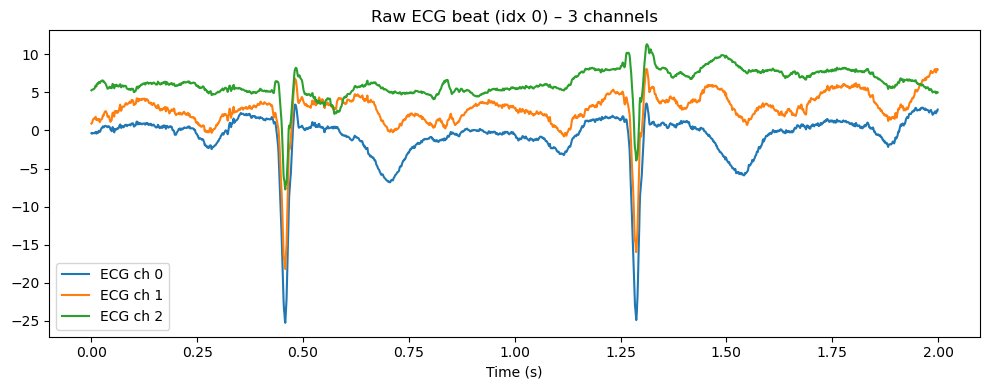

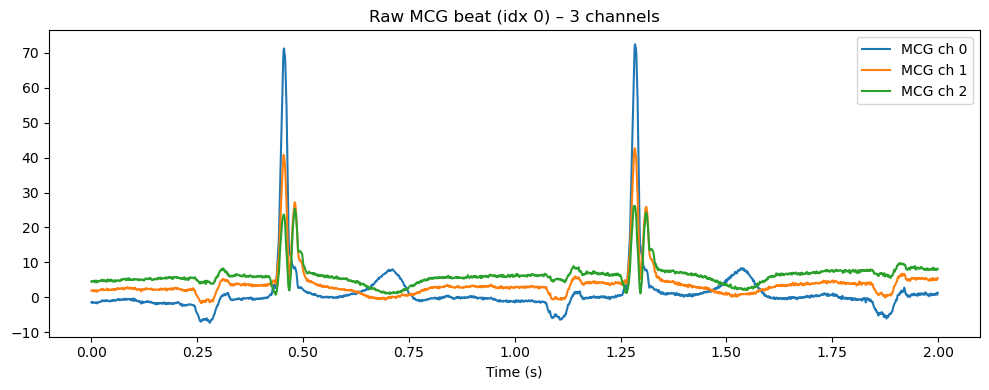

Baseline   pos mean: 0.93513286 neg mean: -0.0012920628
Final SMEE pos mean: 0.71210283 neg mean: -0.009024714


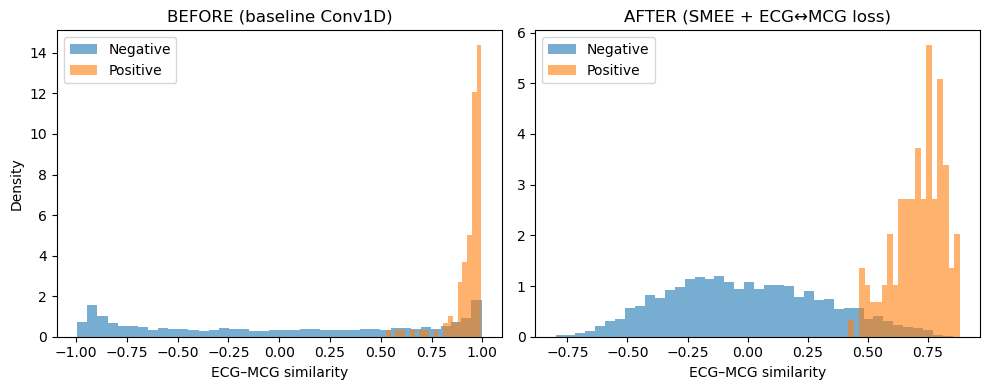

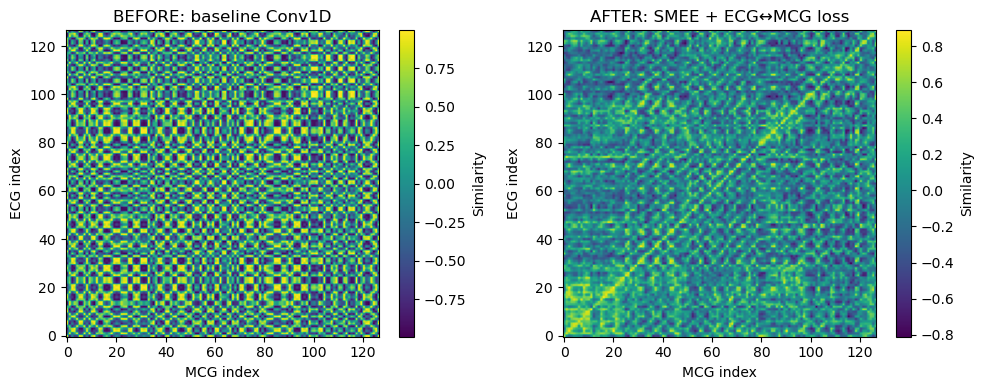

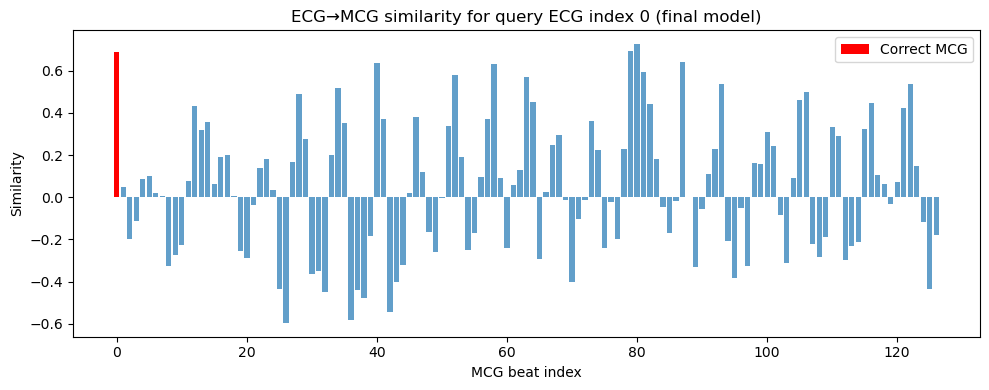

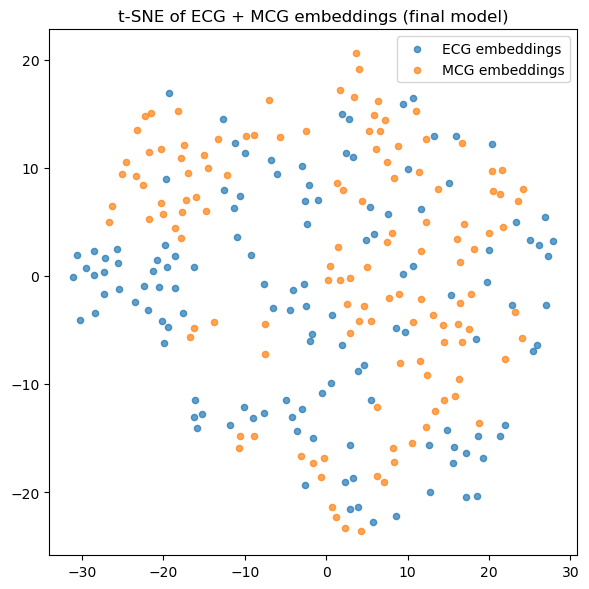

ECG neighbor indices for enhancement: [  0  81  63  40  82 106  28  52  93  87]


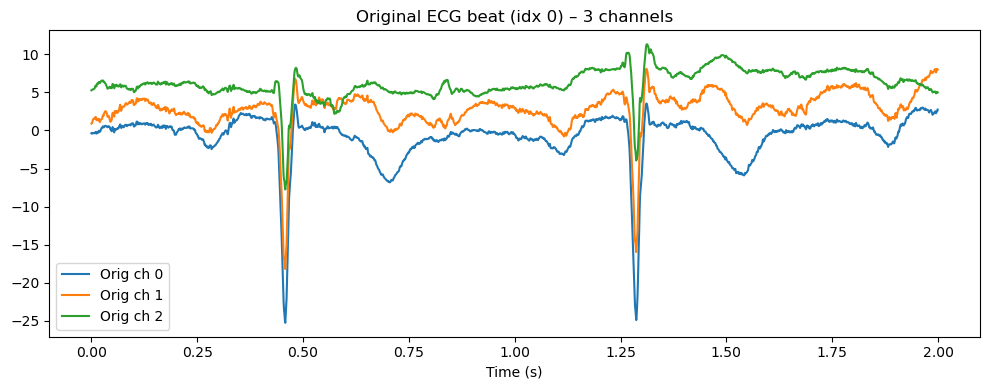

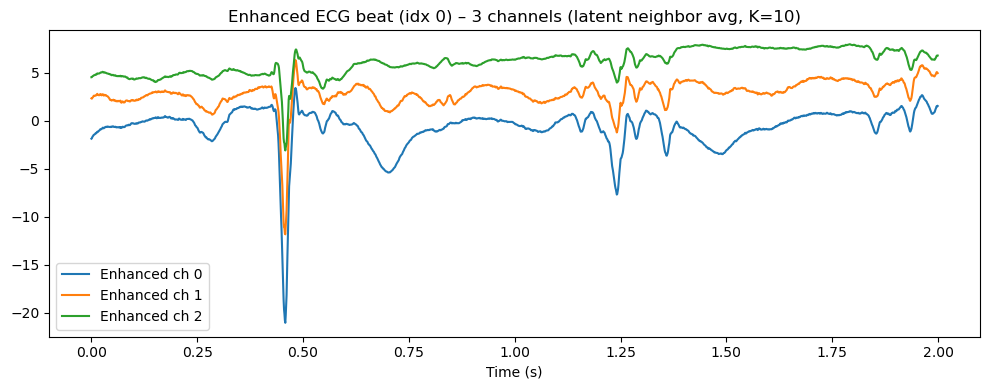

In [24]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

#from koch_dataset import KochPairedBeatsDataset
#rom models import Conv1DEncoder, ECGEncoderSMEE, MCGEncoderSMEE, ProjectionHead

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# -----------------------------
# 0. Load raw beats (for plotting)
# -----------------------------
data_npz = np.load("koch_pairs.npz", allow_pickle=True)
ecg_beats = data_npz["ecg_beats"]  # (N, 32, 2000)
mcg_beats = data_npz["mcg_beats"]  # (N, 100, 2000)
fs = int(data_npz["fs"][0])
N_beats, C_ecg, T = ecg_beats.shape
t = np.arange(T) / fs

# Dataset/loader
ds = KochPairedBeatsDataset(npz_path="koch_pairs.npz", augment=False)
loader = DataLoader(ds, batch_size=64, shuffle=False, num_workers=0)

# -----------------------------
# 1. Compute baseline (Conv1D) embeddings + similarity
# -----------------------------
ecg_enc_base = Conv1DEncoder(in_channels=32, feat_dim=256)
mcg_enc_base = Conv1DEncoder(in_channels=100, feat_dim=256)
ecg_proj_base = ProjectionHead(in_dim=256, proj_dim=128)
mcg_proj_base = ProjectionHead(in_dim=256, proj_dim=128)

ecg_enc_base.load_state_dict(torch.load("ecg_encoder_koch.pth", map_location="cpu"))
mcg_enc_base.load_state_dict(torch.load("mcg_encoder_koch.pth", map_location="cpu"))
ecg_proj_base.load_state_dict(torch.load("ecg_proj_koch.pth", map_location="cpu"))
mcg_proj_base.load_state_dict(torch.load("mcg_proj_koch.pth", map_location="cpu"))

ecg_enc_base.to(device).eval()
mcg_enc_base.to(device).eval()
ecg_proj_base.to(device).eval()
mcg_proj_base.to(device).eval()

all_z_e_base = []
all_z_m_base = []

with torch.no_grad():
    for ecg, mcg in loader:
        ecg = ecg.to(device)
        mcg = mcg.to(device)
        h_e = ecg_enc_base(ecg)
        h_m = mcg_enc_base(mcg)
        z_e = ecg_proj_base(h_e)
        z_m = mcg_proj_base(h_m)
        all_z_e_base.append(z_e.cpu())
        all_z_m_base.append(z_m.cpu())

z_e_base = torch.cat(all_z_e_base, dim=0)  # (N, 128)
z_m_base = torch.cat(all_z_m_base, dim=0)  # (N, 128)
sim_base = (z_e_base @ z_m_base.T).numpy()
print("Baseline sim shape:", sim_base.shape)

# -----------------------------
# 2. Compute final (SMEE + ECG<->MCG loss) embeddings + similarity
# -----------------------------
ecg_enc_final = ECGEncoderSMEE(in_channels=32, bottleneck_channels=32, feat_dim=256)
mcg_enc_final = MCGEncoderSMEE(in_channels=100, bottleneck_channels=32, feat_dim=256)
ecg_proj_final = ProjectionHead(in_dim=256, proj_dim=128)
mcg_proj_final = ProjectionHead(in_dim=256, proj_dim=128)

ecg_enc_final.load_state_dict(torch.load("ecg_encoder_koch_smee_loss.pth", map_location="cpu"))
mcg_enc_final.load_state_dict(torch.load("mcg_encoder_koch_smee_loss.pth", map_location="cpu"))
ecg_proj_final.load_state_dict(torch.load("ecg_proj_koch_smee_loss.pth", map_location="cpu"))
mcg_proj_final.load_state_dict(torch.load("mcg_proj_koch_smee_loss.pth", map_location="cpu"))

ecg_enc_final.to(device).eval()
mcg_enc_final.to(device).eval()
ecg_proj_final.to(device).eval()
mcg_proj_final.to(device).eval()

all_z_e_final = []
all_z_m_final = []

with torch.no_grad():
    for ecg, mcg in loader:
        ecg = ecg.to(device)
        mcg = mcg.to(device)
        h_e = ecg_enc_final(ecg)
        h_m = mcg_enc_final(mcg)
        z_e = ecg_proj_final(h_e)
        z_m = mcg_proj_final(h_m)
        all_z_e_final.append(z_e.cpu())
        all_z_m_final.append(z_m.cpu())

z_e_final = torch.cat(all_z_e_final, dim=0)  # (N, 128)
z_m_final = torch.cat(all_z_m_final, dim=0)  # (N, 128)
sim_final = (z_e_final @ z_m_final.T).numpy()
print("Final sim shape:", sim_final.shape)

# -----------------------------
# Plot 1: Raw input signals (ECG + MCG)
# -----------------------------
example_idx = 0
ecg_ex = ecg_beats[example_idx]  # (32, T)
mcg_ex = mcg_beats[example_idx]  # (100, T)

plt.figure(figsize=(10, 4))
offset = 3.0
for ch in range(3):
    plt.plot(t, ecg_ex[ch] + offset * ch, label=f"ECG ch {ch}")
plt.xlabel("Time (s)")
plt.title(f"Raw ECG beat (idx {example_idx}) – 3 channels")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
offset = 3.0
for ch in range(3):
    plt.plot(t, mcg_ex[ch] + offset * ch, label=f"MCG ch {ch}")
plt.xlabel("Time (s)")
plt.title(f"Raw MCG beat (idx {example_idx}) – 3 channels")
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# Plot 2: Similarity histograms BEFORE vs AFTER
# -----------------------------
def pos_neg(sim_np):
    N = sim_np.shape[0]
    pos = np.diag(sim_np)
    neg = sim_np[~np.eye(N, dtype=bool)]
    if neg.size > 5000:
        idx = np.random.choice(neg.size, 5000, replace=False)
        neg = neg[idx]
    return pos, neg

pos_b, neg_b = pos_neg(sim_base)
pos_f, neg_f = pos_neg(sim_final)

print("Baseline   pos mean:", pos_b.mean(), "neg mean:", neg_b.mean())
print("Final SMEE pos mean:", pos_f.mean(), "neg mean:", neg_f.mean())

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(neg_b, bins=40, alpha=0.6, label="Negative", density=True)
plt.hist(pos_b, bins=20, alpha=0.6, label="Positive", density=True)
plt.title("BEFORE (baseline Conv1D)")
plt.xlabel("ECG–MCG similarity")
plt.ylabel("Density")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(neg_f, bins=40, alpha=0.6, label="Negative", density=True)
plt.hist(pos_f, bins=20, alpha=0.6, label="Positive", density=True)
plt.title("AFTER (SMEE + ECG↔MCG loss)")
plt.xlabel("ECG–MCG similarity")
plt.legend()

plt.tight_layout()
plt.show()

# -----------------------------
# Plot 3: Similarity matrices BEFORE vs AFTER
# -----------------------------
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(sim_base, aspect="auto", origin="lower")
plt.colorbar(label="Similarity")
plt.title("BEFORE: baseline Conv1D")
plt.xlabel("MCG index")
plt.ylabel("ECG index")

plt.subplot(1, 2, 2)
plt.imshow(sim_final, aspect="auto", origin="lower")
plt.colorbar(label="Similarity")
plt.title("AFTER: SMEE + ECG↔MCG loss")
plt.xlabel("MCG index")
plt.ylabel("ECG index")

plt.tight_layout()
plt.show()

# -----------------------------
# Plot 4: Query→retrieval barplot (final model)
# -----------------------------
query_idx = 0
sim_q = sim_final[query_idx]  # (N,)
N = sim_q.shape[0]

plt.figure(figsize=(10, 4))
plt.bar(np.arange(N), sim_q, alpha=0.7)
plt.bar(query_idx, sim_q[query_idx], color="red", label="Correct MCG")
plt.xlabel("MCG beat index")
plt.ylabel("Similarity")
plt.title(f"ECG→MCG similarity for query ECG index {query_idx} (final model)")
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# Plot 5: t-SNE of ECG + MCG embeddings (final model)
# -----------------------------
z_e_np = z_e_final.numpy()
z_m_np = z_m_final.numpy()
Z = np.vstack([z_e_np, z_m_np])  # (2N, 128)
labels = np.array([0] * len(z_e_np) + [1] * len(z_m_np))  # 0=ECG, 1=MCG

tsne = TSNE(n_components=2, perplexity=20, learning_rate=200, init="random", random_state=42)
Z_2d = tsne.fit_transform(Z)

plt.figure(figsize=(6, 6))
plt.scatter(Z_2d[labels == 0, 0], Z_2d[labels == 0, 1], s=20, alpha=0.7, label="ECG embeddings")
plt.scatter(Z_2d[labels == 1, 0], Z_2d[labels == 1, 1], s=20, alpha=0.7, label="MCG embeddings")
plt.legend()
plt.title("t-SNE of ECG + MCG embeddings (final model)")
plt.tight_layout()
plt.show()

# -----------------------------
# Plot 6: Latent-space enhanced ECG vs raw ECG (final model)
# -----------------------------
idx = 0
K = 10  # number of nearest neighbors

query = z_e_final[idx]           # (128,)
Z_all = z_e_final                # (N, 128)

q = query / query.norm()
Z_norm = Z_all / Z_all.norm(dim=1, keepdim=True)
sims_ecg = (Z_norm @ q)          # (N,)

topk = torch.topk(sims_ecg, K)
neighbor_indices = topk.indices.numpy()
print("ECG neighbor indices for enhancement:", neighbor_indices)

orig_ecg = ecg_beats[idx]                          # (32, T)
enh_ecg = ecg_beats[neighbor_indices].mean(axis=0) # (32, T)

channels_to_plot = [0, 1, 2]
offset = 3.0

plt.figure(figsize=(10, 4))
for j, ch in enumerate(channels_to_plot):
    plt.plot(t, orig_ecg[ch] + offset * j, label=f"Orig ch {ch}")
plt.xlabel("Time (s)")
plt.title(f"Original ECG beat (idx {idx}) – 3 channels")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
for j, ch in enumerate(channels_to_plot):
    plt.plot(t, enh_ecg[ch] + offset * j, label=f"Enhanced ch {ch}")
plt.xlabel("Time (s)")
plt.title(f"Enhanced ECG beat (idx {idx}) – 3 channels (latent neighbor avg, K={K})")
plt.legend()
plt.tight_layout()
plt.show()


# PTB Dataset

In [21]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split



class PTBBeatsDataset(Dataset):
    def __init__(self, npz_path="ptb_beats.npz"):
        data = np.load(npz_path, allow_pickle=True)
        print("Keys in NPZ:", data.files)

        X = data["beats"].astype(np.float32)    # (N, 12, 2000)
        y = data["labels"].astype(np.int64)     # (N,)

        # Ensure shape is (N, C, T)
        if X.ndim == 2:
            X = X[:, None, :]

        self.X = X
        self.y = y

        print("PTB X shape:", self.X.shape, "y shape:", self.y.shape)
        print("Unique labels:", np.unique(self.y))

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = self.X[idx]      # (C, T)
        y = self.y[idx]      # scalar
        return torch.from_numpy(x), torch.tensor(y)

# build dataset
ds = PTBBeatsDataset("ptb_beats.npz")

# train/val split (80/20)
n_total = len(ds)
n_train = int(0.8 * n_total)
n_val = n_total - n_train
train_ds, val_ds = random_split(ds, [n_train, n_val])

batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=0)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# infer C, T, num_classes
sample_x, sample_y = ds[0]    # (C, T)
if sample_x.ndim == 1:
    C = 1
    T = sample_x.shape[0]
else:
    C, T = sample_x.shape

classes = np.unique(ds.y)
num_classes = len(classes)
print("C:", C, "T:", T, "num_classes:", num_classes)
if num_classes == 1:
    print("WARNING: only one label class in PTB data. Supervised training will be trivial.")



Keys in NPZ: ['beats', 'record_names', 'subject_ids', 'labels', 'fs', 'description']
PTB X shape: (70507, 12, 2000) y shape: (70507,)
Unique labels: [0]
Using device: cuda
C: 12 T: 2000 num_classes: 1


In [22]:
# =========================================
# 2. SMEE encoder + classifier
# =========================================

class DepthwiseSeparableConv1d(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, stride=1, padding=0):
        super().__init__()
        self.depthwise = nn.Conv1d(
            in_ch, in_ch, kernel_size=kernel_size,
            stride=stride, padding=padding, groups=in_ch
        )
        self.pointwise = nn.Conv1d(in_ch, out_ch, kernel_size=1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class MultiScaleBlock(nn.Module):
    def __init__(self, channels, kernels=(5, 9, 17)):
        super().__init__()
        self.branches = nn.ModuleList()
        for k in kernels:
            pad = k // 2
            self.branches.append(
                DepthwiseSeparableConv1d(channels, channels, kernel_size=k, padding=pad)
            )
        self.bn = nn.BatchNorm1d(channels)
        self.act = nn.ReLU()

    def forward(self, x):
        outs = [conv(x) for conv in self.branches]
        out = sum(outs) / len(outs)
        out = self.bn(out)
        out = self.act(out)
        return x + out

class SMEEBackbone(nn.Module):
    def __init__(self, bottleneck_channels=32, n_blocks=3, feat_dim=256):
        super().__init__()
        blocks = [
            MultiScaleBlock(bottleneck_channels, kernels=(5, 9, 17))
            for _ in range(n_blocks)
        ]
        self.blocks = nn.Sequential(*blocks)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(bottleneck_channels, feat_dim)

    def forward(self, x):
        x = self.blocks(x)                     # (B, Cb, T)
        x = self.global_pool(x).squeeze(-1)    # (B, Cb)
        x = self.fc(x)                         # (B, feat_dim)
        return x

class ECGEncoderSMEE(nn.Module):
    def __init__(self, in_channels=12, bottleneck_channels=32, feat_dim=256):
        super().__init__()
        self.input_proj = nn.Conv1d(in_channels, bottleneck_channels, kernel_size=1)
        self.backbone = SMEEBackbone(
            bottleneck_channels=bottleneck_channels,
            n_blocks=3,
            feat_dim=feat_dim
        )

    def forward(self, x):
        x = self.input_proj(x)
        x = self.backbone(x)
        return x  # (B, feat_dim)

class PTBClassifier(nn.Module):
    def __init__(self, in_channels=12, bottleneck_channels=32,
                 feat_dim=256, num_classes=2):
        super().__init__()
        self.encoder = ECGEncoderSMEE(
            in_channels=in_channels,
            bottleneck_channels=bottleneck_channels,
            feat_dim=feat_dim
        )
        self.classifier = nn.Linear(feat_dim, num_classes)

    def forward(self, x):
        h = self.encoder(x)          # (B, feat_dim)
        logits = self.classifier(h)  # (B, num_classes)
        return logits, h


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# =========================================
# 1. PTB SimCLR Dataset (two augmented views)
# =========================================

class PTBBeatsDataset(Dataset):
    def __init__(self, npz_path="ptb_beats.npz", augment=True):
        data = np.load(npz_path, allow_pickle=True)
        self.beats = data["beats"]        # (N, 12, 2000)
        self.fs = int(data["fs"][0])
        self.augment = augment

    def __len__(self):
        return self.beats.shape[0]

    def _augment(self, x, noise_sigma=0.01, max_shift=20):
        # x: (12, T)
        x = x + noise_sigma * np.random.randn(*x.shape).astype(np.float32)
        shift = np.random.randint(-max_shift, max_shift + 1)
        if shift != 0:
            x = np.roll(x, shift, axis=1)
        return x

    def __getitem__(self, idx):
        x = self.beats[idx]  # (12, 2000)

        x1 = self._augment(x.copy())
        x2 = self._augment(x.copy())

        x1 = torch.from_numpy(x1)  # (12, 2000)
        x2 = torch.from_numpy(x2)
        return x1, x2

ds = PTBBeatsDataset("ptb_beats.npz", augment=True)
print("Num PTB beats:", len(ds))
loader = DataLoader(ds, batch_size=64, shuffle=True, num_workers=0)
v1, v2 = next(iter(loader))
print("Batch shapes:", v1.shape, v2.shape)  # [B, 12, 2000]


# =========================================
# 2. SMEE ECG encoder (same idea as Koch, but in_channels=12)
# =========================================

class DepthwiseSeparableConv1d(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, stride=1, padding=0):
        super().__init__()
        self.depthwise = nn.Conv1d(
            in_ch, in_ch, kernel_size=kernel_size,
            stride=stride, padding=padding, groups=in_ch
        )
        self.pointwise = nn.Conv1d(in_ch, out_ch, kernel_size=1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class MultiScaleBlock(nn.Module):
    def __init__(self, channels, kernels=(5, 9, 17)):
        super().__init__()
        self.branches = nn.ModuleList()
        for k in kernels:
            pad = k // 2
            self.branches.append(
                DepthwiseSeparableConv1d(channels, channels, kernel_size=k, padding=pad)
            )
        self.bn = nn.BatchNorm1d(channels)
        self.act = nn.ReLU()

    def forward(self, x):
        outs = [conv(x) for conv in self.branches]
        out = sum(outs) / len(outs)
        out = self.bn(out)
        out = self.act(out)
        return x + out

class SMEEBackbone(nn.Module):
    def __init__(self, bottleneck_channels=32, n_blocks=3, feat_dim=256):
        super().__init__()
        blocks = [
            MultiScaleBlock(bottleneck_channels, kernels=(5, 9, 17))
            for _ in range(n_blocks)
        ]
        self.blocks = nn.Sequential(*blocks)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(bottleneck_channels, feat_dim)

    def forward(self, x):
        x = self.blocks(x)                     # (B, Cb, T)
        x = self.global_pool(x).squeeze(-1)    # (B, Cb)
        x = self.fc(x)                         # (B, feat_dim)
        return x

class ECGEncoderSMEE(nn.Module):
    def __init__(self, in_channels=12, bottleneck_channels=32, feat_dim=256):
        super().__init__()
        self.input_proj = nn.Conv1d(in_channels, bottleneck_channels, kernel_size=1)
        self.backbone = SMEEBackbone(
            bottleneck_channels=bottleneck_channels,
            n_blocks=3,
            feat_dim=feat_dim
        )

    def forward(self, x):
        x = self.input_proj(x)
        x = self.backbone(x)
        return x  # (B, feat_dim)

class ProjectionHead(nn.Module):
    def __init__(self, in_dim=256, proj_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, in_dim)
        self.fc2 = nn.Linear(in_dim, proj_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.normalize(x, p=2, dim=-1)
        return x


# =========================================
# 3. SimCLR NT-Xent loss (unchanged)
# =========================================

def simclr_nt_xent(z1, z2, temperature=0.1):
    B, D = z1.shape
    z1 = F.normalize(z1, dim=-1)
    z2 = F.normalize(z2, dim=-1)

    z = torch.cat([z1, z2], dim=0)  # (2B, D)
    sim = z @ z.T                   # (2B, 2B)

    mask = torch.eye(2 * B, dtype=torch.bool, device=z.device)
    sim = sim / temperature

    labels = torch.arange(2 * B, device=z.device)
    labels = (labels + B) % (2 * B)

    sim_masked = sim[~mask].view(2 * B, -1)
    positives = sim[torch.arange(2 * B, device=z.device), labels].unsqueeze(-1)
    logits = torch.cat([positives, sim_masked], dim=1)

    targets = torch.zeros(2 * B, dtype=torch.long, device=z.device)
    loss = F.cross_entropy(logits, targets)
    return loss


# =========================================
# 4. Train SMEE on PTB (SimCLR)
# =========================================

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

ecg_encoder = ECGEncoderSMEE(in_channels=12, bottleneck_channels=32, feat_dim=256).to(device)
proj_head  = ProjectionHead(in_dim=256, proj_dim=128).to(device)

optimizer_enc = torch.optim.Adam(ecg_encoder.parameters(), lr=1e-3)
optimizer_head = torch.optim.Adam(proj_head.parameters(), lr=1e-3)

num_epochs = 3

for epoch in range(1, num_epochs + 1):
    ecg_encoder.train()
    proj_head.train()

    running_loss = 0.0
    count = 0

    for v1, v2 in loader:
        v1 = v1.to(device)  # (B, 12, 2000)
        v2 = v2.to(device)

        optimizer_enc.zero_grad()
        optimizer_head.zero_grad()

        h1 = ecg_encoder(v1)   # (B, 256)
        h2 = ecg_encoder(v2)   # (B, 256)

        z1 = proj_head(h1)     # (B, 128)
        z2 = proj_head(h2)     # (B, 128)

        loss = simclr_nt_xent(z1, z2, temperature=0.1)
        loss.backward()
        optimizer_enc.step()
        optimizer_head.step()

        running_loss += loss.item() * v1.size(0)
        count += v1.size(0)

    avg_loss = running_loss / count
    print(f"Epoch {epoch:03d}/{num_epochs} - SMEE SimCLR loss: {avg_loss:.4f}")

# =========================================
# 5. Save PTB SMEE encoder
# =========================================

torch.save(ecg_encoder.state_dict(), "ecg_encoder_ptb_smee_simclr.pth")
print("Saved PTB SMEE SimCLR ECG encoder to ecg_encoder_ptb_smee_simclr.pth")


Num PTB beats: 70507
Batch shapes: torch.Size([64, 12, 2000]) torch.Size([64, 12, 2000])
Using device: cuda
Epoch 001/3 - SMEE SimCLR loss: 0.7331
Epoch 002/3 - SMEE SimCLR loss: 0.7057
Epoch 003/3 - SMEE SimCLR loss: 0.7041
Saved PTB SMEE SimCLR ECG encoder to ecg_encoder_ptb_smee_simclr.pth


## Evaluation

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# =========================================
# 1. Load PTB beats + metadata
# =========================================

data = np.load("ptb_beats.npz", allow_pickle=True)
beats = data["beats"]             # (N, 12, 2000)
record_names = data["record_names"]  # (N,)
subject_ids = data["subject_ids"]    # (N,)

N = beats.shape[0]
print("Total PTB beats:", N)

# Use a subset for evaluation to keep it fast
N_eval = min(2000, N) 
beats_eval = beats[:N_eval]
rec_eval = record_names[:N_eval]
subj_eval = subject_ids[:N_eval]

print("Using", N_eval, "beats for evaluation")


# =========================================
# 2. Define the SAME SMEE encoder as in training
# =========================================

class DepthwiseSeparableConv1d(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, stride=1, padding=0):
        super().__init__()
        self.depthwise = nn.Conv1d(
            in_ch, in_ch, kernel_size=kernel_size,
            stride=stride, padding=padding, groups=in_ch
        )
        self.pointwise = nn.Conv1d(in_ch, out_ch, kernel_size=1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class MultiScaleBlock(nn.Module):
    def __init__(self, channels, kernels=(5, 9, 17)):
        super().__init__()
        self.branches = nn.ModuleList()
        for k in kernels:
            pad = k // 2
            self.branches.append(
                DepthwiseSeparableConv1d(channels, channels, kernel_size=k, padding=pad)
            )
        self.bn = nn.BatchNorm1d(channels)
        self.act = nn.ReLU()

    def forward(self, x):
        outs = [conv(x) for conv in self.branches]
        out = sum(outs) / len(outs)
        out = self.bn(out)
        out = self.act(out)
        return x + out

class SMEEBackbone(nn.Module):
    def __init__(self, bottleneck_channels=32, n_blocks=3, feat_dim=256):
        super().__init__()
        blocks = [
            MultiScaleBlock(bottleneck_channels, kernels=(5, 9, 17))
            for _ in range(n_blocks)
        ]
        self.blocks = nn.Sequential(*blocks)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(bottleneck_channels, feat_dim)

    def forward(self, x):
        x = self.blocks(x)                     # (B, Cb, T)
        x = self.global_pool(x).squeeze(-1)    # (B, Cb)
        x = self.fc(x)                         # (B, feat_dim)
        return x

class ECGEncoderSMEE(nn.Module):
    def __init__(self, in_channels=12, bottleneck_channels=32, feat_dim=256):
        super().__init__()
        self.input_proj = nn.Conv1d(in_channels, bottleneck_channels, kernel_size=1)
        self.backbone = SMEEBackbone(
            bottleneck_channels=bottleneck_channels,
            n_blocks=3,
            feat_dim=feat_dim
        )

    def forward(self, x):
        x = self.input_proj(x)
        x = self.backbone(x)
        return x  # (B, feat_dim)


# =========================================
# 3. Load trained PTB SMEE encoder weights
# =========================================

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

encoder = ECGEncoderSMEE(in_channels=12, bottleneck_channels=32, feat_dim=256).to(device)
state_dict = torch.load("ecg_encoder_ptb_smee_simclr.pth", map_location=device)
encoder.load_state_dict(state_dict)
encoder.eval()

# =========================================
# 4. Compute embeddings for a subset of beats
# =========================================

batch_size = 128
emb_list = []

with torch.no_grad():
    for i in range(0, N_eval, batch_size):
        x = beats_eval[i:i+batch_size]           # (B, 12, 2000)
        x = torch.from_numpy(x).to(device)
        h = encoder(x)                           # (B, 256)
        h = F.normalize(h, dim=-1)               # L2 normalize
        emb_list.append(h.cpu().numpy())

emb = np.concatenate(emb_list, axis=0)          # (N_eval, 256)
print("Embedding shape:", emb.shape)

# =========================================
# 5. Nearest neighbor evaluation (subject / record)
# =========================================

# cosine similarity matrix
sim = emb @ emb.T  # (N_eval, N_eval)

N_eval = sim.shape[0]
nn_idx = np.zeros(N_eval, dtype=int)

for i in range(N_eval):
    s = sim[i].copy()
    s[i] = -1e9            # ignore self
    nn_idx[i] = np.argmax(s)

# Top-1 neighbor has same subject?
top1_same_subject = np.mean(subj_eval == subj_eval[nn_idx])

# Top-1 neighbor has same record?
top1_same_record = np.mean(rec_eval == rec_eval[nn_idx])

print("Top-1 NN same SUBJECT ID :", top1_same_subject)
print("Top-1 NN same RECORD name:", top1_same_record)

# =========================================
# 6. Average similarity: same-subject vs different-subject (rough estimate)
# =========================================

rng = np.random.default_rng(0)
num_pairs = 5000 if N_eval > 5000 else N_eval * 2

same_sims = []
diff_sims = []

for _ in range(num_pairs):
    i, j = rng.integers(0, N_eval, size=2)
    if i == j:
        continue
    if subj_eval[i] == subj_eval[j]:
        same_sims.append(sim[i, j])
    else:
        diff_sims.append(sim[i, j])

same_sims = np.array(same_sims)
diff_sims = np.array(diff_sims)

print("Mean sim (same subject):     ", same_sims.mean() if len(same_sims) > 0 else None)
print("Mean sim (different subject):", diff_sims.mean() if len(diff_sims) > 0 else None)


Total PTB beats: 70507
Using 2000 beats for evaluation
Using device: cuda
Embedding shape: (2000, 256)
Top-1 NN same SUBJECT ID : 0.9865
Top-1 NN same RECORD name: 0.8925
Mean sim (same subject):      0.60358
Mean sim (different subject): 0.34105843


# Final COP

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# =========================================
# 1. Dataset: Koch paired ECG–MCG beats
# =========================================

class KochPairedBeatsDataset(Dataset):
    def __init__(self, npz_path="koch_pairs.npz", augment=True):
        data = np.load(npz_path, allow_pickle=True)
        self.ecg_beats = data["ecg_beats"].astype(np.float32)  # (N, 32, 2000)
        self.mcg_beats = data["mcg_beats"].astype(np.float32)  # (N, 100, 2000)
        self.fs = int(data["fs"][0])
        self.augment = augment

    def __len__(self):
        return self.ecg_beats.shape[0]

    def _augment(self, x, noise_sigma=0.01, max_shift=20):
        x = x + noise_sigma * np.random.randn(*x.shape).astype(np.float32)
        shift = np.random.randint(-max_shift, max_shift + 1)
        if shift != 0:
            x = np.roll(x, shift, axis=1)
        return x

    def __getitem__(self, idx):
        ecg = self.ecg_beats[idx]   # (32, T)
        mcg = self.mcg_beats[idx]   # (100, T)

        if self.augment:
            ecg = self._augment(ecg)
            mcg = self._augment(mcg)

        return torch.from_numpy(ecg), torch.from_numpy(mcg)


# quick dataset check
tmp_ds = KochPairedBeatsDataset("koch_pairs.npz", augment=False)
print("Koch beats:", tmp_ds.ecg_beats.shape, tmp_ds.mcg_beats.shape)


# =========================================
# 2. SMEE encoders (same design as PTB, but ECG:32ch, MCG:100ch)
# =========================================

class DepthwiseSeparableConv1d(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, stride=1, padding=0):
        super().__init__()
        self.depthwise = nn.Conv1d(
            in_ch, in_ch, kernel_size=kernel_size,
            stride=stride, padding=padding, groups=in_ch
        )
        self.pointwise = nn.Conv1d(in_ch, out_ch, kernel_size=1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x


class MultiScaleBlock(nn.Module):
    def __init__(self, channels, kernels=(5, 9, 17)):
        super().__init__()
        self.branches = nn.ModuleList()
        for k in kernels:
            pad = k // 2
            self.branches.append(
                DepthwiseSeparableConv1d(channels, channels, kernel_size=k, padding=pad)
            )
        self.bn = nn.BatchNorm1d(channels)
        self.act = nn.ReLU()

    def forward(self, x):
        outs = [conv(x) for conv in self.branches]
        out = sum(outs) / len(outs)
        out = self.bn(out)
        out = self.act(out)
        return x + out


class SMEEBackbone(nn.Module):
    def __init__(self, bottleneck_channels=32, n_blocks=3, feat_dim=256):
        super().__init__()
        blocks = [
            MultiScaleBlock(bottleneck_channels, kernels=(5, 9, 17))
            for _ in range(n_blocks)
        ]
        self.blocks = nn.Sequential(*blocks)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(bottleneck_channels, feat_dim)

    def forward(self, x):
        x = self.blocks(x)                     # (B, Cb, T)
        x = self.global_pool(x).squeeze(-1)    # (B, Cb)
        x = self.fc(x)                         # (B, feat_dim)
        return x


class ECGEncoderSMEE(nn.Module):
    def __init__(self, in_channels=32, bottleneck_channels=32, feat_dim=256):
        super().__init__()
        self.input_proj = nn.Conv1d(in_channels, bottleneck_channels, kernel_size=1)
        self.backbone = SMEEBackbone(
            bottleneck_channels=bottleneck_channels,
            n_blocks=3,
            feat_dim=feat_dim
        )

    def forward(self, x):
        x = self.input_proj(x)
        x = self.backbone(x)
        return x  # (B, feat_dim)


class MCGEncoderSMEE(nn.Module):
    def __init__(self, in_channels=100, bottleneck_channels=32, feat_dim=256):
        super().__init__()
        self.input_proj = nn.Conv1d(in_channels, bottleneck_channels, kernel_size=1)
        self.backbone = SMEEBackbone(
            bottleneck_channels=bottleneck_channels,
            n_blocks=3,
            feat_dim=feat_dim
        )

    def forward(self, x):
        x = self.input_proj(x)
        x = self.backbone(x)
        return x  # (B, feat_dim)


class ProjectionHead(nn.Module):
    def __init__(self, in_dim=256, proj_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, in_dim)
        self.fc2 = nn.Linear(in_dim, proj_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.normalize(x, p=2, dim=-1)
        return x


# =========================================
# 3. Losses: cross-modal + within-modality
# =========================================

def cross_modal_info_nce(z_e, z_m, temperature=0.1):
    """
    Symmetric InfoNCE between ECG (z_e) and MCG (z_m).
    z_e, z_m: (B, D), assumed L2-normalized.
    """
    B, D = z_e.shape
    # similarity
    logits = z_e @ z_m.T / temperature          # (B, B)
    targets = torch.arange(B, device=z_e.device)

    loss_e2m = F.cross_entropy(logits, targets)
    loss_m2e = F.cross_entropy(logits.T, targets)
    return 0.5 * (loss_e2m + loss_m2e)


def within_nt_xent(z, temperature=0.1, noise_std=0.01):
    """
    Simple within-modality contrastive term:
    create a noisy copy z2 of z1 and apply InfoNCE between them.
    """
    z1 = F.normalize(z, dim=-1)
    z2 = z1 + noise_std * torch.randn_like(z1)
    z2 = F.normalize(z2, dim=-1)
    return cross_modal_info_nce(z1, z2, temperature=temperature)


def ecg_mcg_joint_loss(z_e, z_m, lambda_within=0.1,
                       temp_cross=0.1, temp_within=0.1):
    L_cross = cross_modal_info_nce(z_e, z_m, temperature=temp_cross)
    L_within_e = within_nt_xent(z_e, temperature=temp_within)
    L_within_m = within_nt_xent(z_m, temperature=temp_within)
    return L_cross + lambda_within * (L_within_e + L_within_m)


# =========================================
# 4. Load PTB SMEE weights into Koch ECG encoder backbone
# =========================================

def load_ptb_smee_backbone_into_koch_ecg(koch_ecg_encoder, ptb_ckpt_path):
    """
    Load SMEE backbone weights from PTB-trained ECGEncoderSMEE (12ch)
    into Koch ECGEncoderSMEE (32ch). We copy only 'backbone.*' keys.
    input_proj stays random (different in_channels).
    """
    ptb_state = torch.load(ptb_ckpt_path, map_location="cpu")
    koch_state = koch_ecg_encoder.state_dict()

    new_state = {}
    for k, v in koch_state.items():
        if k.startswith("backbone.") and (k in ptb_state) and (ptb_state[k].shape == v.shape):
            new_state[k] = ptb_state[k]
        else:
            new_state[k] = v

    koch_ecg_encoder.load_state_dict(new_state)
    print("Loaded PTB SMEE backbone into Koch ECG encoder (input_proj kept random).")


# =========================================
# 5. Train Koch with PTB-initialized ECG encoder
# =========================================

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

batch_size = 8
epochs = 50
lambda_within = 0.1

train_ds = KochPairedBeatsDataset("koch_pairs.npz", augment=True)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)

ecg_encoder = ECGEncoderSMEE(in_channels=32, bottleneck_channels=32, feat_dim=256).to(device)
mcg_encoder = MCGEncoderSMEE(in_channels=100, bottleneck_channels=32, feat_dim=256).to(device)

load_ptb_smee_backbone_into_koch_ecg(ecg_encoder, "ecg_encoder_ptb_smee_simclr.pth")

ecg_proj = ProjectionHead(in_dim=256, proj_dim=128).to(device)
mcg_proj = ProjectionHead(in_dim=256, proj_dim=128).to(device)

params = list(ecg_encoder.parameters()) + list(mcg_encoder.parameters()) + \
         list(ecg_proj.parameters()) + list(mcg_proj.parameters())

optimizer = torch.optim.AdamW(params, lr=1e-3, weight_decay=1e-4)

for epoch in range(1, epochs + 1):
    ecg_encoder.train()
    mcg_encoder.train()
    ecg_proj.train()
    mcg_proj.train()

    running_loss = 0.0
    n_batches = 0

    for ecg, mcg in train_loader:
        ecg = ecg.to(device)  # (B, 32, T)
        mcg = mcg.to(device)  # (B, 100, T)

        optimizer.zero_grad()

        h_e = ecg_encoder(ecg)      # (B, 256)
        h_m = mcg_encoder(mcg)      # (B, 256)

        z_e = ecg_proj(h_e)         # (B, 128)
        z_m = mcg_proj(h_m)         # (B, 128)

        loss = ecg_mcg_joint_loss(
            z_e, z_m,
            lambda_within=lambda_within,
            temp_cross=0.1,
            temp_within=0.1
        )

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        n_batches += 1

    avg_loss = running_loss / max(1, n_batches)
    print(f"Epoch {epoch:03d}/{epochs} - Koch SMEE ECG<->MCG loss: {avg_loss:.4f} (λ_within={lambda_within})")

# Save models
torch.save(ecg_encoder.state_dict(), "koch_smee_ecg_encoder_ptbinit.pth")
torch.save(mcg_encoder.state_dict(), "koch_smee_mcg_encoder_ptbinit.pth")
torch.save(ecg_proj.state_dict(), "koch_smee_ecg_proj_ptbinit.pth")
torch.save(mcg_proj.state_dict(), "koch_smee_mcg_proj_ptbinit.pth")
print("Saved Koch SMEE encoders + projection heads (PTB-initialized).")


# =========================================
# 6. Retrieval evaluation: ECG→MCG and MCG→ECG
# =========================================

eval_ds = KochPairedBeatsDataset("koch_pairs.npz", augment=False)
eval_loader = DataLoader(eval_ds, batch_size=32, shuffle=False, num_workers=0)

ecg_encoder.eval()
mcg_encoder.eval()
ecg_proj.eval()
mcg_proj.eval()

ecg_emb_list = []
mcg_emb_list = []

with torch.no_grad():
    for ecg, mcg in eval_loader:
        ecg = ecg.to(device)
        mcg = mcg.to(device)

        h_e = ecg_encoder(ecg)
        h_m = mcg_encoder(mcg)

        z_e = ecg_proj(h_e)   # (B, 128)
        z_m = mcg_proj(h_m)

        ecg_emb_list.append(z_e.cpu().numpy())
        mcg_emb_list.append(z_m.cpu().numpy())

ecg_emb = np.concatenate(ecg_emb_list, axis=0)  # (N, D)
mcg_emb = np.concatenate(mcg_emb_list, axis=0)  # (N, D)

# normalize again for safety
ecg_emb = ecg_emb / np.linalg.norm(ecg_emb, axis=1, keepdims=True)
mcg_emb = mcg_emb / np.linalg.norm(mcg_emb, axis=1, keepdims=True)

N, D = ecg_emb.shape
print("Eval embeddings shape:", ecg_emb.shape, mcg_emb.shape)

# similarity matrix
sim = ecg_emb @ mcg_emb.T  # (N, N)

def retrieval_stats(sim_matrix):
    N = sim_matrix.shape[0]
    top1 = 0
    top5 = 0
    for i in range(N):
        row = sim_matrix[i]
        idx_sorted = np.argsort(-row)  # descending
        if idx_sorted[0] == i:
            top1 += 1
        if i in idx_sorted[:5]:
            top5 += 1
    return top1 / N, top5 / N

ecg_to_mcg_top1, ecg_to_mcg_top5 = retrieval_stats(sim)
mcg_to_ecg_top1, mcg_to_ecg_top5 = retrieval_stats(sim.T)

print("Koch SMEE + PTB-SMEE init retrieval:")
print(f"ECG→MCG top-1: {ecg_to_mcg_top1*100:.2f}% | top-5: {ecg_to_mcg_top5*100:.2f}%")
print(f"MCG→ECG top-1: {mcg_to_ecg_top1*100:.2f}% | top-5: {mcg_to_ecg_top5*100:.2f}%")


Koch beats: (127, 32, 2000) (127, 100, 2000)
Using device: cuda
Loaded PTB SMEE backbone into Koch ECG encoder (input_proj kept random).
Epoch 001/50 - Koch SMEE ECG<->MCG loss: 2.4459 (λ_within=0.1)
Epoch 002/50 - Koch SMEE ECG<->MCG loss: 2.2871 (λ_within=0.1)
Epoch 003/50 - Koch SMEE ECG<->MCG loss: 1.9799 (λ_within=0.1)
Epoch 004/50 - Koch SMEE ECG<->MCG loss: 1.9261 (λ_within=0.1)
Epoch 005/50 - Koch SMEE ECG<->MCG loss: 1.7893 (λ_within=0.1)
Epoch 006/50 - Koch SMEE ECG<->MCG loss: 1.5250 (λ_within=0.1)
Epoch 007/50 - Koch SMEE ECG<->MCG loss: 1.5684 (λ_within=0.1)
Epoch 008/50 - Koch SMEE ECG<->MCG loss: 1.3018 (λ_within=0.1)
Epoch 009/50 - Koch SMEE ECG<->MCG loss: 1.0446 (λ_within=0.1)
Epoch 010/50 - Koch SMEE ECG<->MCG loss: 0.9139 (λ_within=0.1)
Epoch 011/50 - Koch SMEE ECG<->MCG loss: 0.8363 (λ_within=0.1)
Epoch 012/50 - Koch SMEE ECG<->MCG loss: 0.7540 (λ_within=0.1)
Epoch 013/50 - Koch SMEE ECG<->MCG loss: 0.6489 (λ_within=0.1)
Epoch 014/50 - Koch SMEE ECG<->MCG loss: 0.5